In [1]:
import numpy as np
import pickle as pkl
import torch
from torch import nn
from models.encoders.gru import GRUTPPEncoder
from models.decoders.rmtpp import RMTPPDecoder, RMTPPLoss
from models import TPPModel, VAETPPModel
from utils.evaluatetpp import evaluate_tpp_model, evaluate_vae_model, calculate_event_metrics
from utils.data_processing import preprocess_data, collate_fn, EventDataset
from utils.plotting import plot_seqs, plot_seqs_both, plot_latent_space_vae, plot_latent_space_tpp, plot_samples_vae
import pandas as pd
from easy_tpp.config_factory import DataSpecConfig
from torch.utils.data import DataLoader


C:\Users\miche\anaconda3\Lib\site-packages\pandas\core\arrays\masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


In [2]:
dev_dict = pkl.load(open('data/taxi/dev.pkl', 'rb'))
test_dict = pkl.load(open('data/taxi/test.pkl', 'rb'))
train_dict = pkl.load(open('data/taxi/train.pkl', 'rb'))

train_data = train_dict['train']
test_data = test_dict['test']
dev_data = dev_dict['dev']

In [3]:
dim_process = train_dict['dim_process']
config = DataSpecConfig.parse_from_yaml_config({
    'num_event_types': dim_process,
    'pad_token_id': dim_process
})

In [4]:
# Create datasets
preprocessed_train = preprocess_data(train_data)
preprocessed_test = preprocess_data(test_data)

train_dataset = EventDataset(preprocessed_train)
test_dataset = EventDataset(preprocessed_test)

# Create data loaders with collate function and arguments to prepare_data
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, collate_fn=lambda batch: collate_fn(batch, config), drop_last=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, collate_fn=lambda batch: collate_fn(batch, config), drop_last=False)

### Train/retrieve RMTPP Model

In [5]:
HIDDEN_DIM = 128
MLP_DIM = 64
device = 'cpu' if not torch.cuda.is_available() else 'cuda'

tpp_model = TPPModel(config, hidden_dim=HIDDEN_DIM, mlp_dim=MLP_DIM, device=device).to(device)

# Training loop
num_epochs = 200
optimizer = torch.optim.Adam(tpp_model.parameters(), lr=0.001)

# load the model
try:
    tpp_model.load_state_dict(torch.load('models/tpp_model.pt',map_location=torch.device('cpu')))
    print("Model loaded successfully, skipping training.")
except FileNotFoundError:
    print("Model not found, starting training from scratch.")

    for epoch in range(num_epochs):
        tpp_model.train()
        total_train_loss = 0
        for batch in train_loader:
            batch = {k: v.to(device) for k, v in batch.items()}
            optimizer.zero_grad()
            decoder_output = tpp_model(batch)
            time_loss, mark_loss, total_loss = tpp_model.compute_loss(batch, decoder_output)
            total_loss.backward()
            optimizer.step()
            total_train_loss += total_loss.item()

        avg_train_loss = total_train_loss / len(train_loader)
        print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {avg_train_loss:.4f}")

        # Evaluate on test data
        tpp_model.eval()
        total_test_loss = 0
        with torch.no_grad():
            for batch in test_loader:
                batch = {k: v.to(device) for k, v in batch.items()}
                decoder_output = tpp_model(batch)
                _, _, total_loss = tpp_model.compute_loss(batch, decoder_output)
                total_test_loss += total_loss.item()

        avg_test_loss = total_test_loss / len(test_loader)
        print(f"Epoch {epoch+1}/{num_epochs}, Test Loss: {avg_test_loss:.4f}")

Model loaded successfully, skipping training.


C:\Users\miche\AppData\Local\Temp\ipykernel_20876\2945928441.py:13: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  tpp_model.load_state_dict(torch.load('models/tpp_model.pt',

In [6]:
# save model
torch.save(tpp_model.state_dict(), 'models/tpp_model.pt')

In [7]:
tpp_eval_metrics = evaluate_tpp_model(tpp_model, test_loader, config, device=device)

C:\Users\miche\Other\Documents\GitHub\ProbabilisticTPP\utils\evaluatetpp.py:97: RuntimeWarning: overflow encountered in exp
  - np.exp(


In [8]:
tpp_eval_metrics

{'time_mae': 0.02947391023772662,
 'time_rmse': 0.04039178767351144,
 'event_accuracy': 0.9997975708502024,
 'event_total': 14820,
 'type_metrics': {'type_0': {'precision': 1.0, 'recall': 1.0, 'f1': 1.0},
  'type_1': {'precision': 1.0, 'recall': 1.0, 'f1': 1.0},
  'type_2': {'precision': 1.0, 'recall': 1.0, 'f1': 1.0},
  'type_3': {'precision': 1.0, 'recall': 1.0, 'f1': 1.0},
  'type_4': {'precision': 1.0, 'recall': 1.0, 'f1': 1.0},
  'type_5': {'precision': 0.9982014388489209,
   'recall': 1.0,
   'f1': 0.9990999099909991},
  'type_6': {'precision': 1.0, 'recall': 1.0, 'f1': 1.0},
  'type_7': {'precision': 0.6, 'recall': 1.0, 'f1': 0.7499999999999999},
  'type_8': {'precision': 1.0,
   'recall': 0.9998495788206979,
   'f1': 0.9999247837532907},
  'type_9': {'precision': 0, 'recall': 0.0, 'f1': 0}},
 'predicted_intervals': [0.0,
  0.2391543401578637,
  0.18408739942249674,
  0.06388425702523781,
  0.024078272558110236,
  0.1298030916444064,
  0.09194621048414209,
  0.13207950012279457,

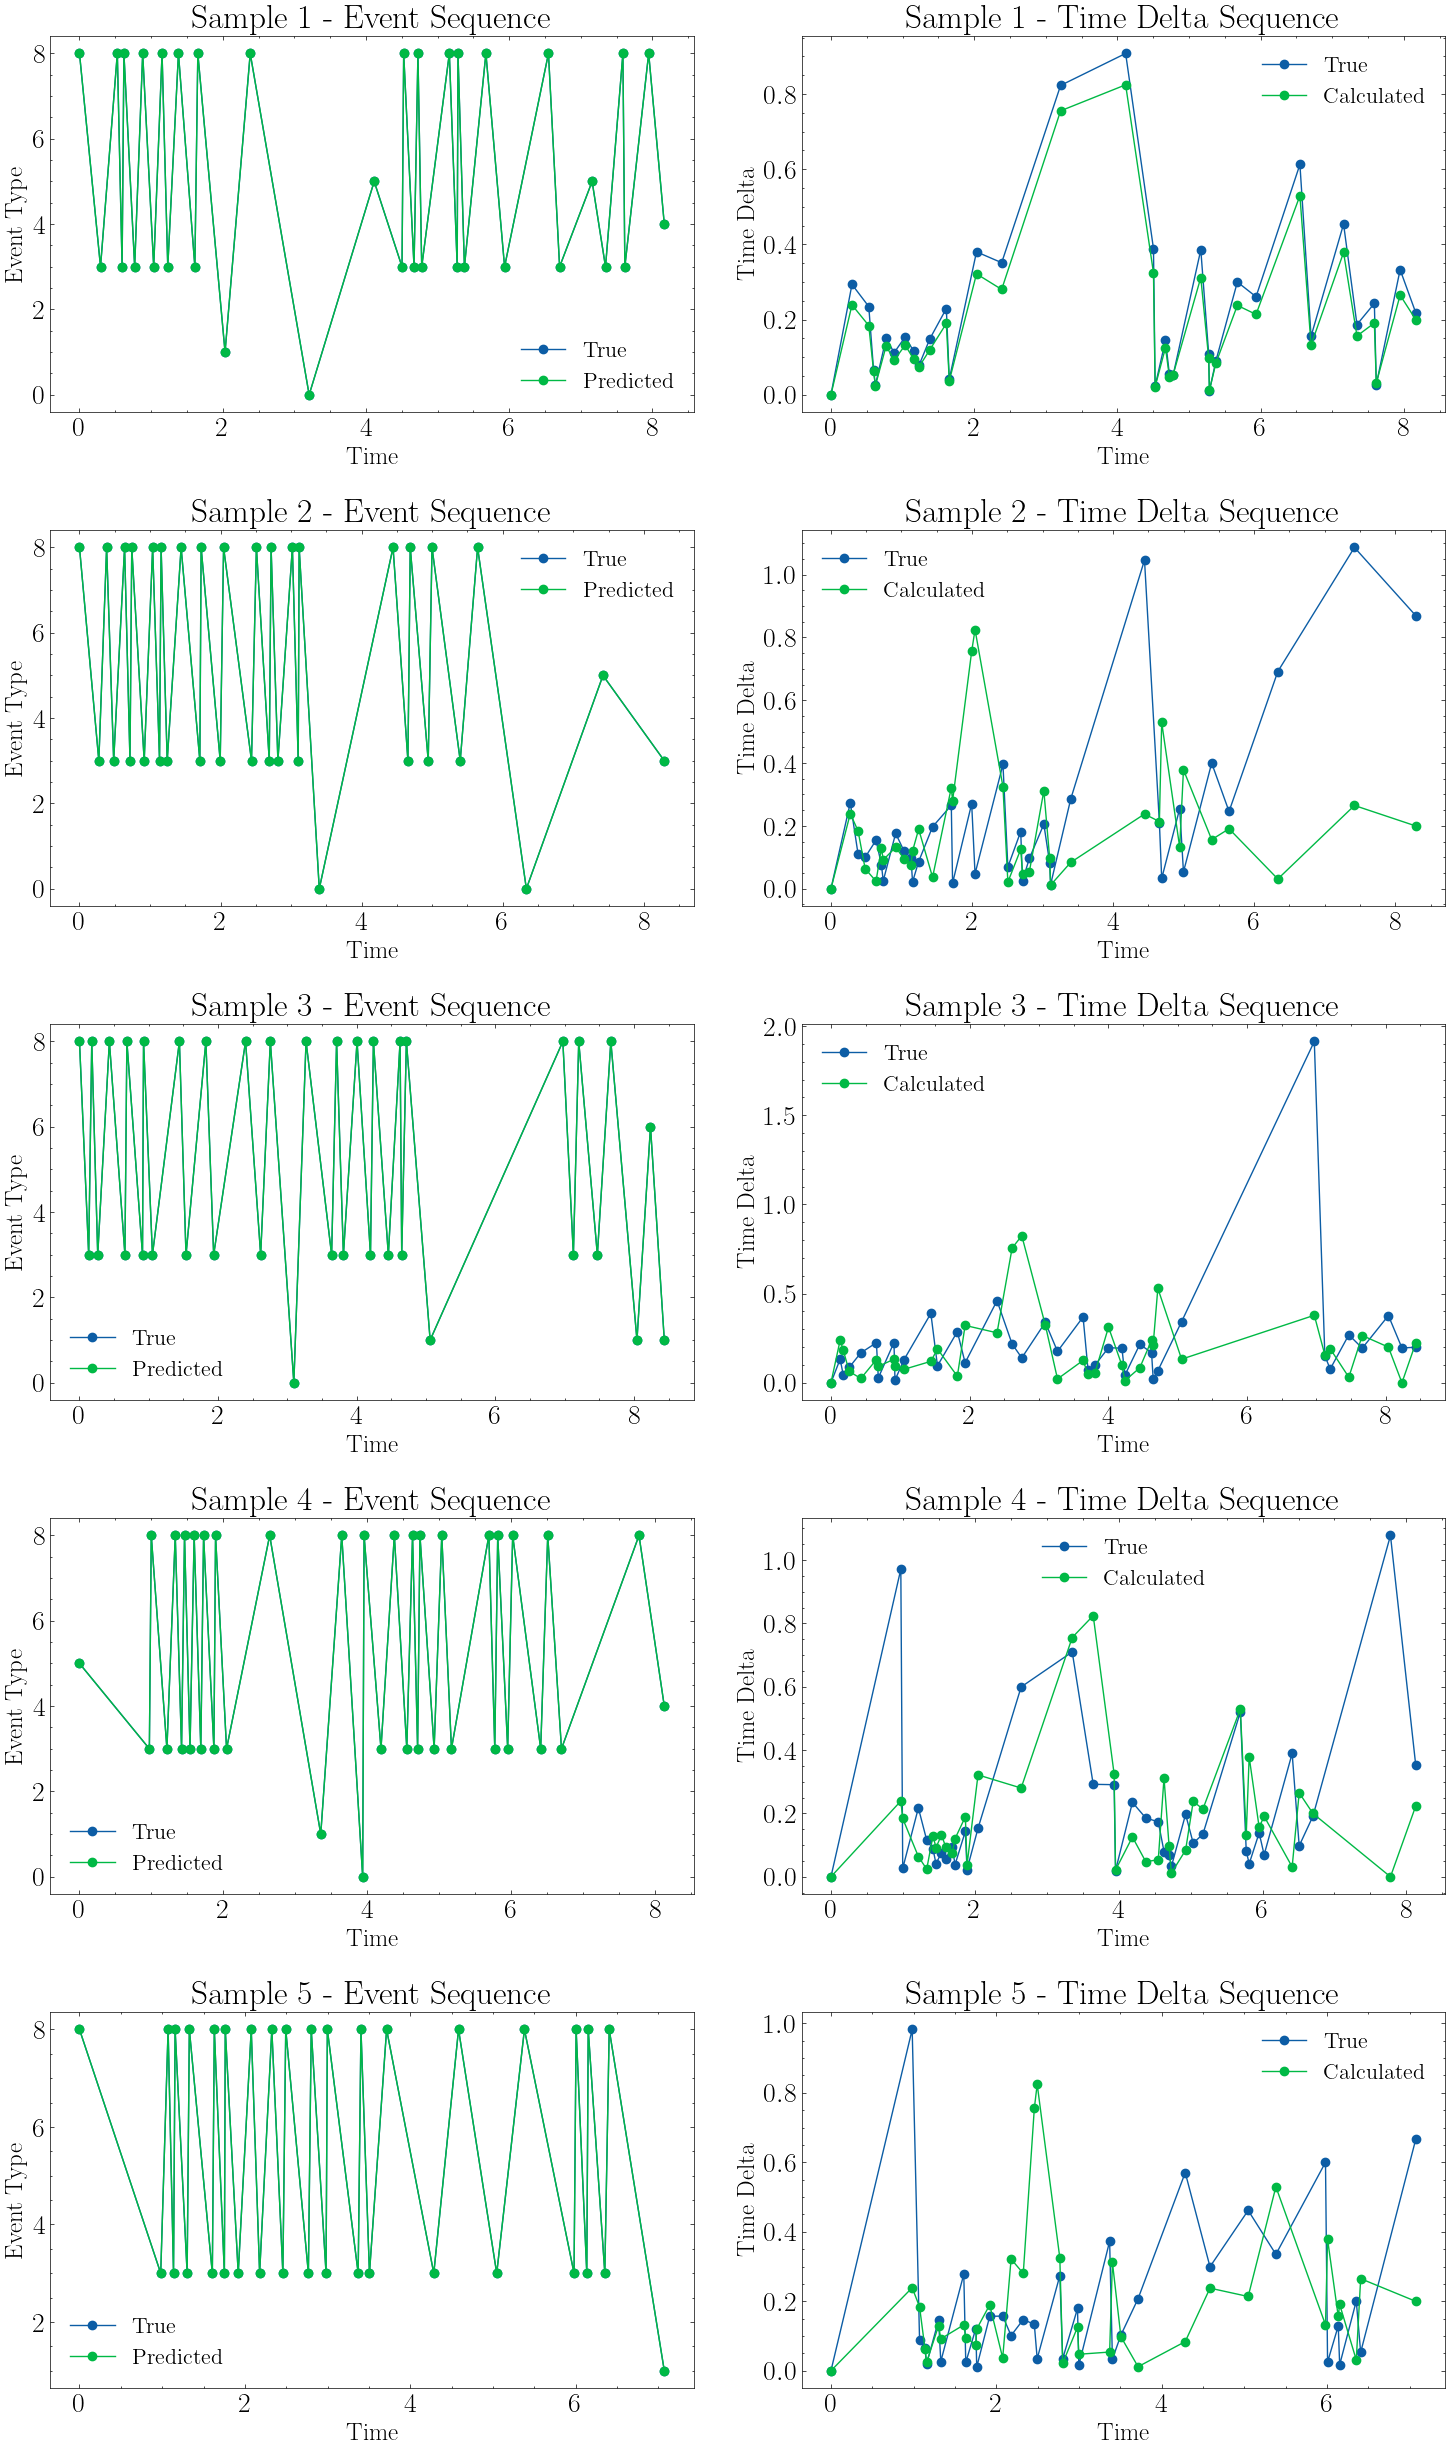

In [9]:
for batch in test_loader:
    batch = {k: v.to(device) for k, v in batch.items()}
    decoder_output = tpp_model(batch)
    plot_seqs(
        batch['time_seqs'], 
        batch['type_seqs'], 
        batch['time_delta_seqs'], 
        batch['sequence_length'], 
        tpp_eval_metrics['predicted_intervals'], 
        decoder_output,
        file_name='tpp_event_sequence.png'
    )
    break

### Train/retrieve VAETPP Model

In [10]:
# reload VAETPPModel
import importlib
import models
importlib.reload(models)
from models import TPPModel, VAETPPModel

HIDDEN_DIM = 128
LATENT_DIM = 32
MLP_DIM = 64
device = 'cpu' if not torch.cuda.is_available() else 'cuda'

# calculate the number of steps for beta annealing and warmup
num_epochs = 200
num_steps = len(train_loader) * num_epochs
cyclic_steps = num_steps // 5
warmup_steps = len(train_loader) * 20

vae_model = VAETPPModel(config, hidden_dim=HIDDEN_DIM, latent_dim=LATENT_DIM, mlp_dim=MLP_DIM, device=device, beta_steps=num_steps, warmup_steps=warmup_steps, beta_start=0, beta_end=0.5, l1_lambda=0.000, l2_lambda=0.000).to(device)
optimizer = torch.optim.Adam(vae_model.parameters(), lr=0.001)

# One cycle learning rate scheduler
scheduler = torch.optim.lr_scheduler.OneCycleLR(
    optimizer,
    max_lr=0.001,
    steps_per_epoch=len(train_loader),
    epochs=num_epochs,
    anneal_strategy='cos',
)

# try loading the model
try:
    vae_model.load_state_dict(torch.load('models/vae_model.pt',map_location=torch.device('cpu')))
    print("Model loaded successfully, skipping training.")
except FileNotFoundError:
    print("Model not found, starting training from scratch.")

    # Training loop with beta annealing
    for epoch in range(num_epochs):
        vae_model.train()
        total_train_loss = 0
        for step, batch in enumerate(train_loader):
            batch = {k: v.to(device) for k, v in batch.items()}
            optimizer.zero_grad()
            decoder_output = vae_model(batch)
            time_loss, mark_loss, total_loss = vae_model.compute_loss(batch, decoder_output)
            total_loss.backward()
            optimizer.step()
            scheduler.step()
            total_train_loss += total_loss.item()
        avg_train_loss = total_train_loss / len(train_loader)
        print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {avg_train_loss:.4f}")

        vae_model.eval()
        total_test_loss = 0
        with torch.no_grad():
            for batch in test_loader:
                batch = {k: v.to(device) for k, v in batch.items()}
                decoder_output = vae_model(batch)
                _, _, total_loss = vae_model.compute_loss(batch, decoder_output)
                total_test_loss += total_loss.item()

        avg_test_loss = total_test_loss / len(test_loader)
        print(f"Epoch {epoch+1}/{num_epochs}, Test Loss: {avg_test_loss:.4f}")


Model loaded successfully, skipping training.


C:\Users\miche\AppData\Local\Temp\ipykernel_20876\33949005.py:32: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  vae_model.load_state_dict(torch.load('models/vae_model.pt',ma

In [11]:
# save model
torch.save(vae_model.state_dict(), 'models/vae_model.pt')

In [12]:
vae_eval_metrics = evaluate_vae_model(vae_model, test_loader, config, device=device)

C:\Users\miche\Other\Documents\GitHub\ProbabilisticTPP\utils\evaluatetpp.py:238: RuntimeWarning: overflow encountered in exp
  - np.exp(


In [13]:
vae_eval_metrics

{'time_mae': 0.06759575453170745,
 'time_rmse': 0.12880827065464548,
 'event_accuracy': 0.990080971659919,
 'event_total': 14820,
 'type_metrics': {'type_0': {'precision': 0.9823943661971831,
   'recall': 0.9928825622775801,
   'f1': 0.9876106194690265},
  'type_1': {'precision': 0.9899749373433584,
   'recall': 0.9899749373433584,
   'f1': 0.9899749373433584},
  'type_2': {'precision': 0, 'recall': 0.0, 'f1': 0},
  'type_3': {'precision': 0.9921948173587262,
   'recall': 0.9939014855355747,
   'f1': 0.9930474181704555},
  'type_4': {'precision': 0.5,
   'recall': 0.21052631578947367,
   'f1': 0.2962962962962963},
  'type_5': {'precision': 0.9875444839857651,
   'recall': 1.0,
   'f1': 0.9937332139659804},
  'type_6': {'precision': 0.8878923766816144,
   'recall': 0.9801980198019802,
   'f1': 0.9317647058823529},
  'type_7': {'precision': 0, 'recall': 0.0, 'f1': 0},
  'type_8': {'precision': 0.9935299428227505,
   'recall': 0.993231046931408,
   'f1': 0.9933804723935611},
  'type_9': {

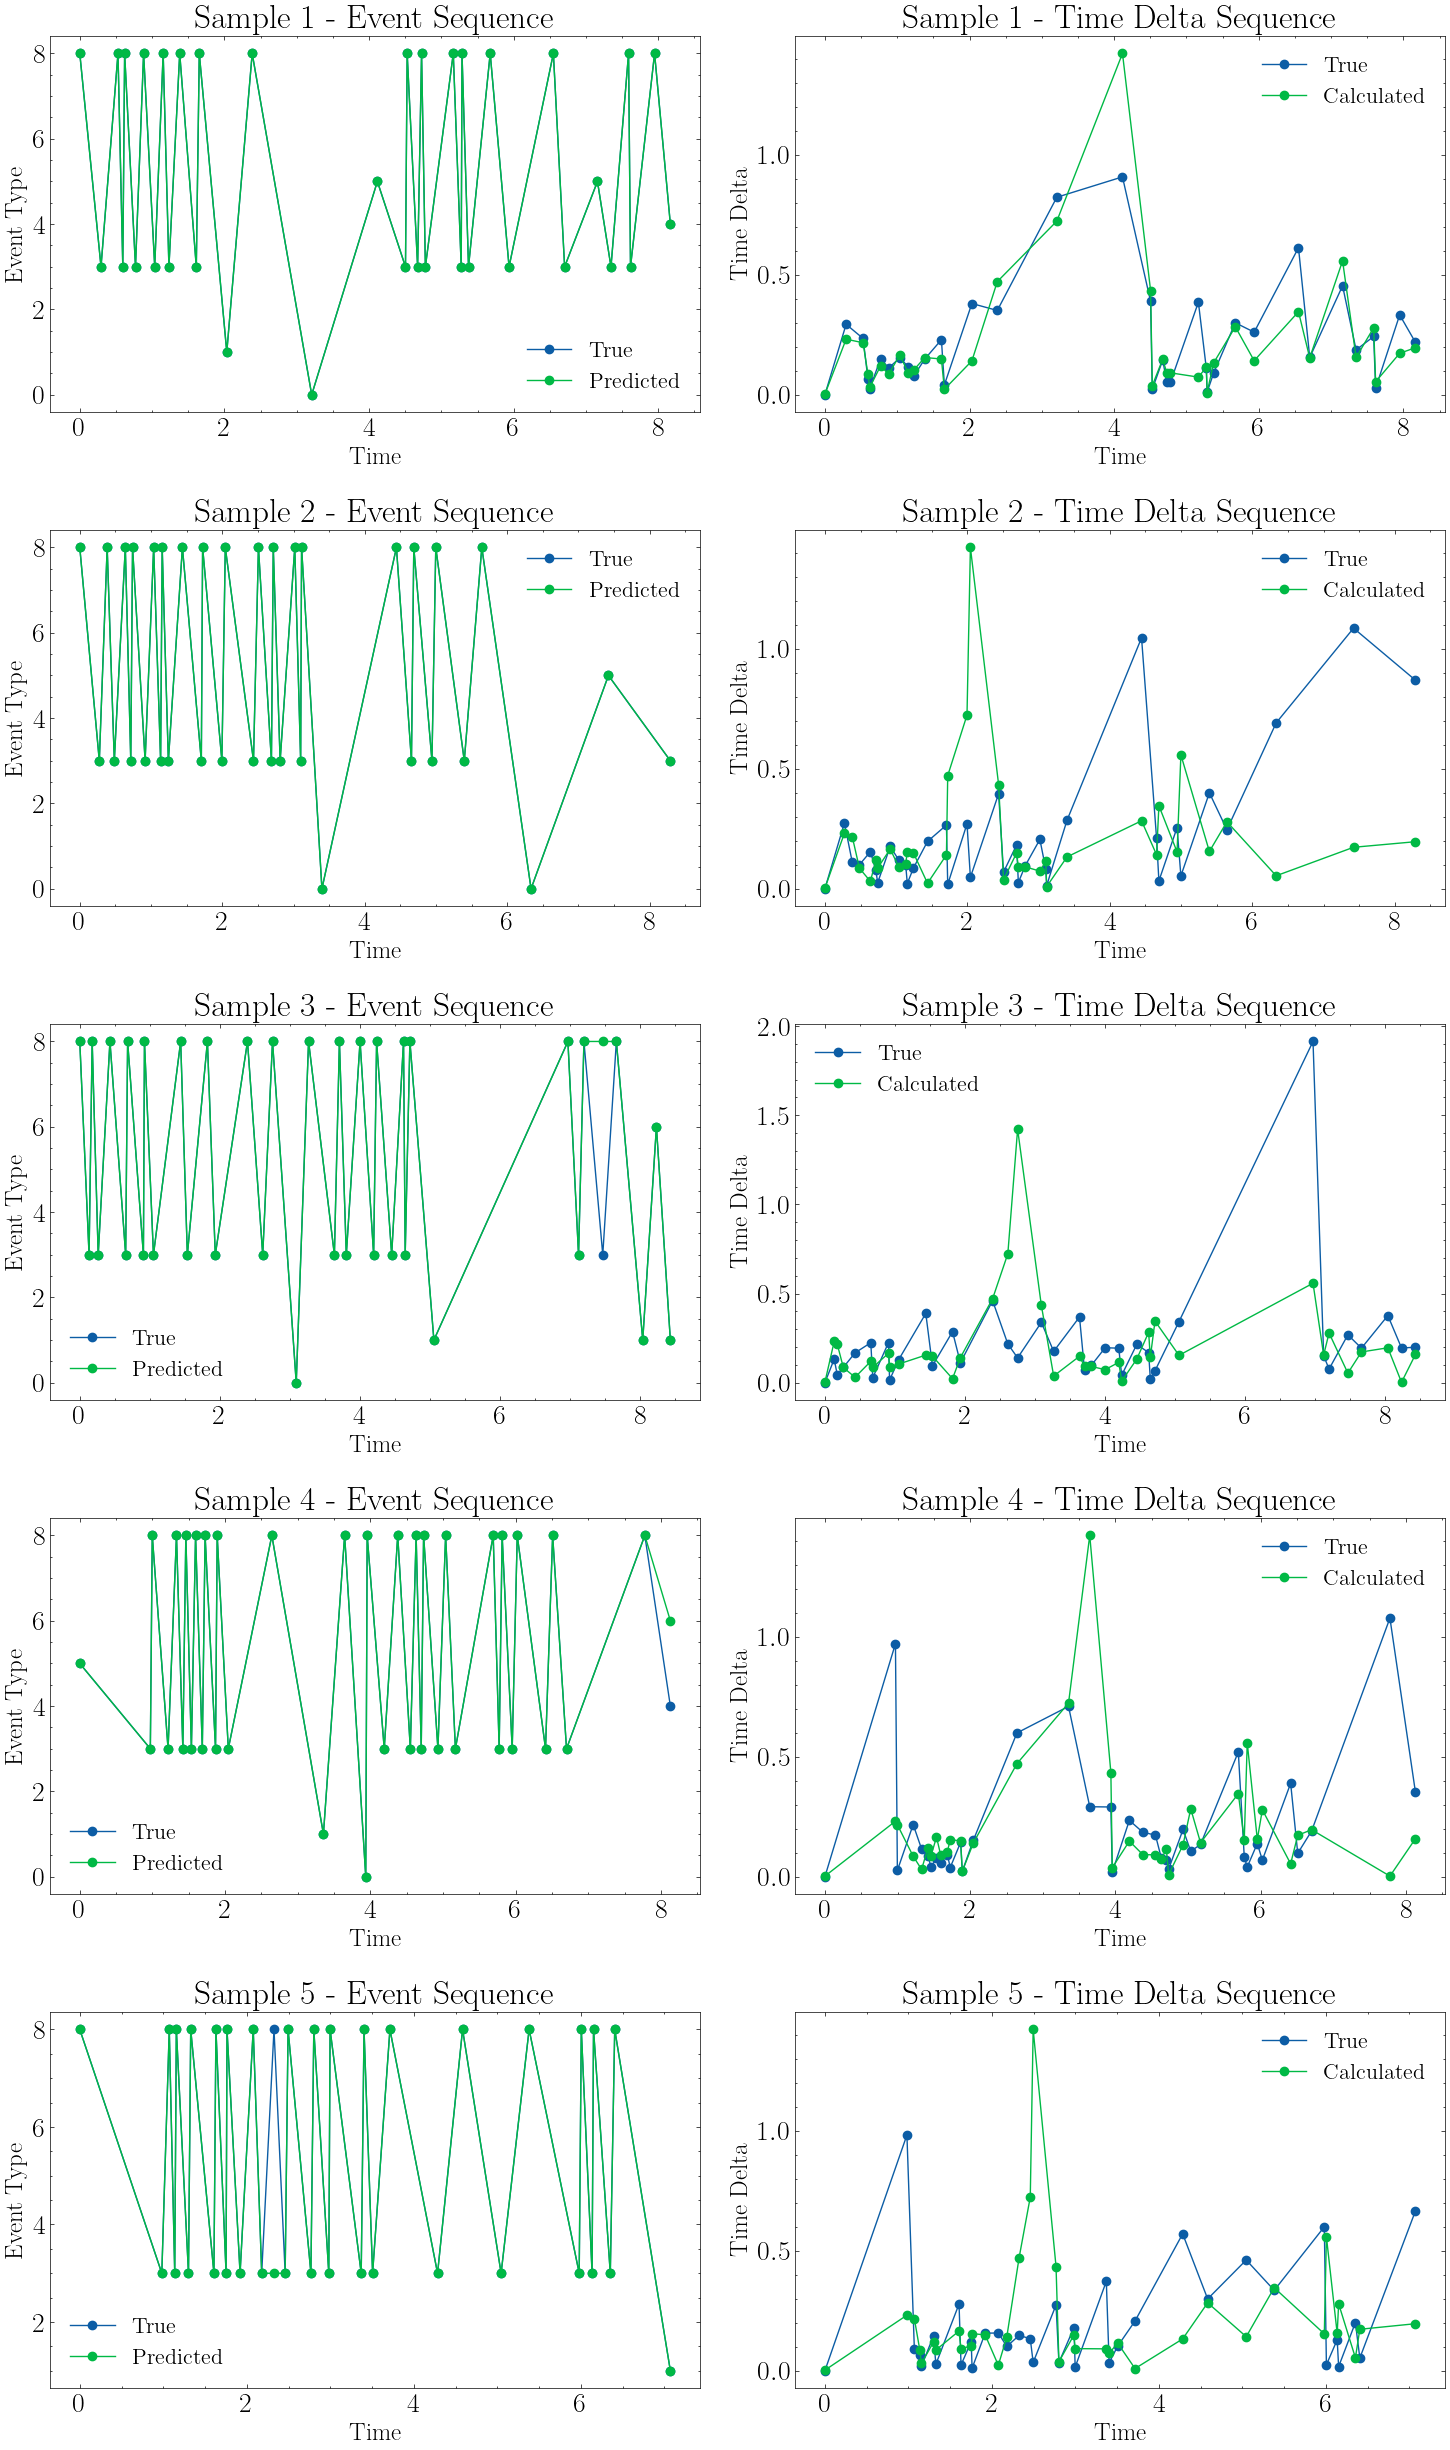

In [14]:
# plot the event sequences and the predicted event sequences
for batch in test_loader:
    batch = {k: v.to(device) for k, v in batch.items()}
    decoder_output = vae_model(batch)
    plot_seqs(
        batch['time_seqs'], 
        batch['type_seqs'], 
        batch['time_delta_seqs'], 
        batch['sequence_length'], 
        vae_eval_metrics['predicted_intervals'], 
        decoder_output,
        file_name='vae_event_sequence.png'
    )
    break

### Visualize both RMTPP and VAE sequences

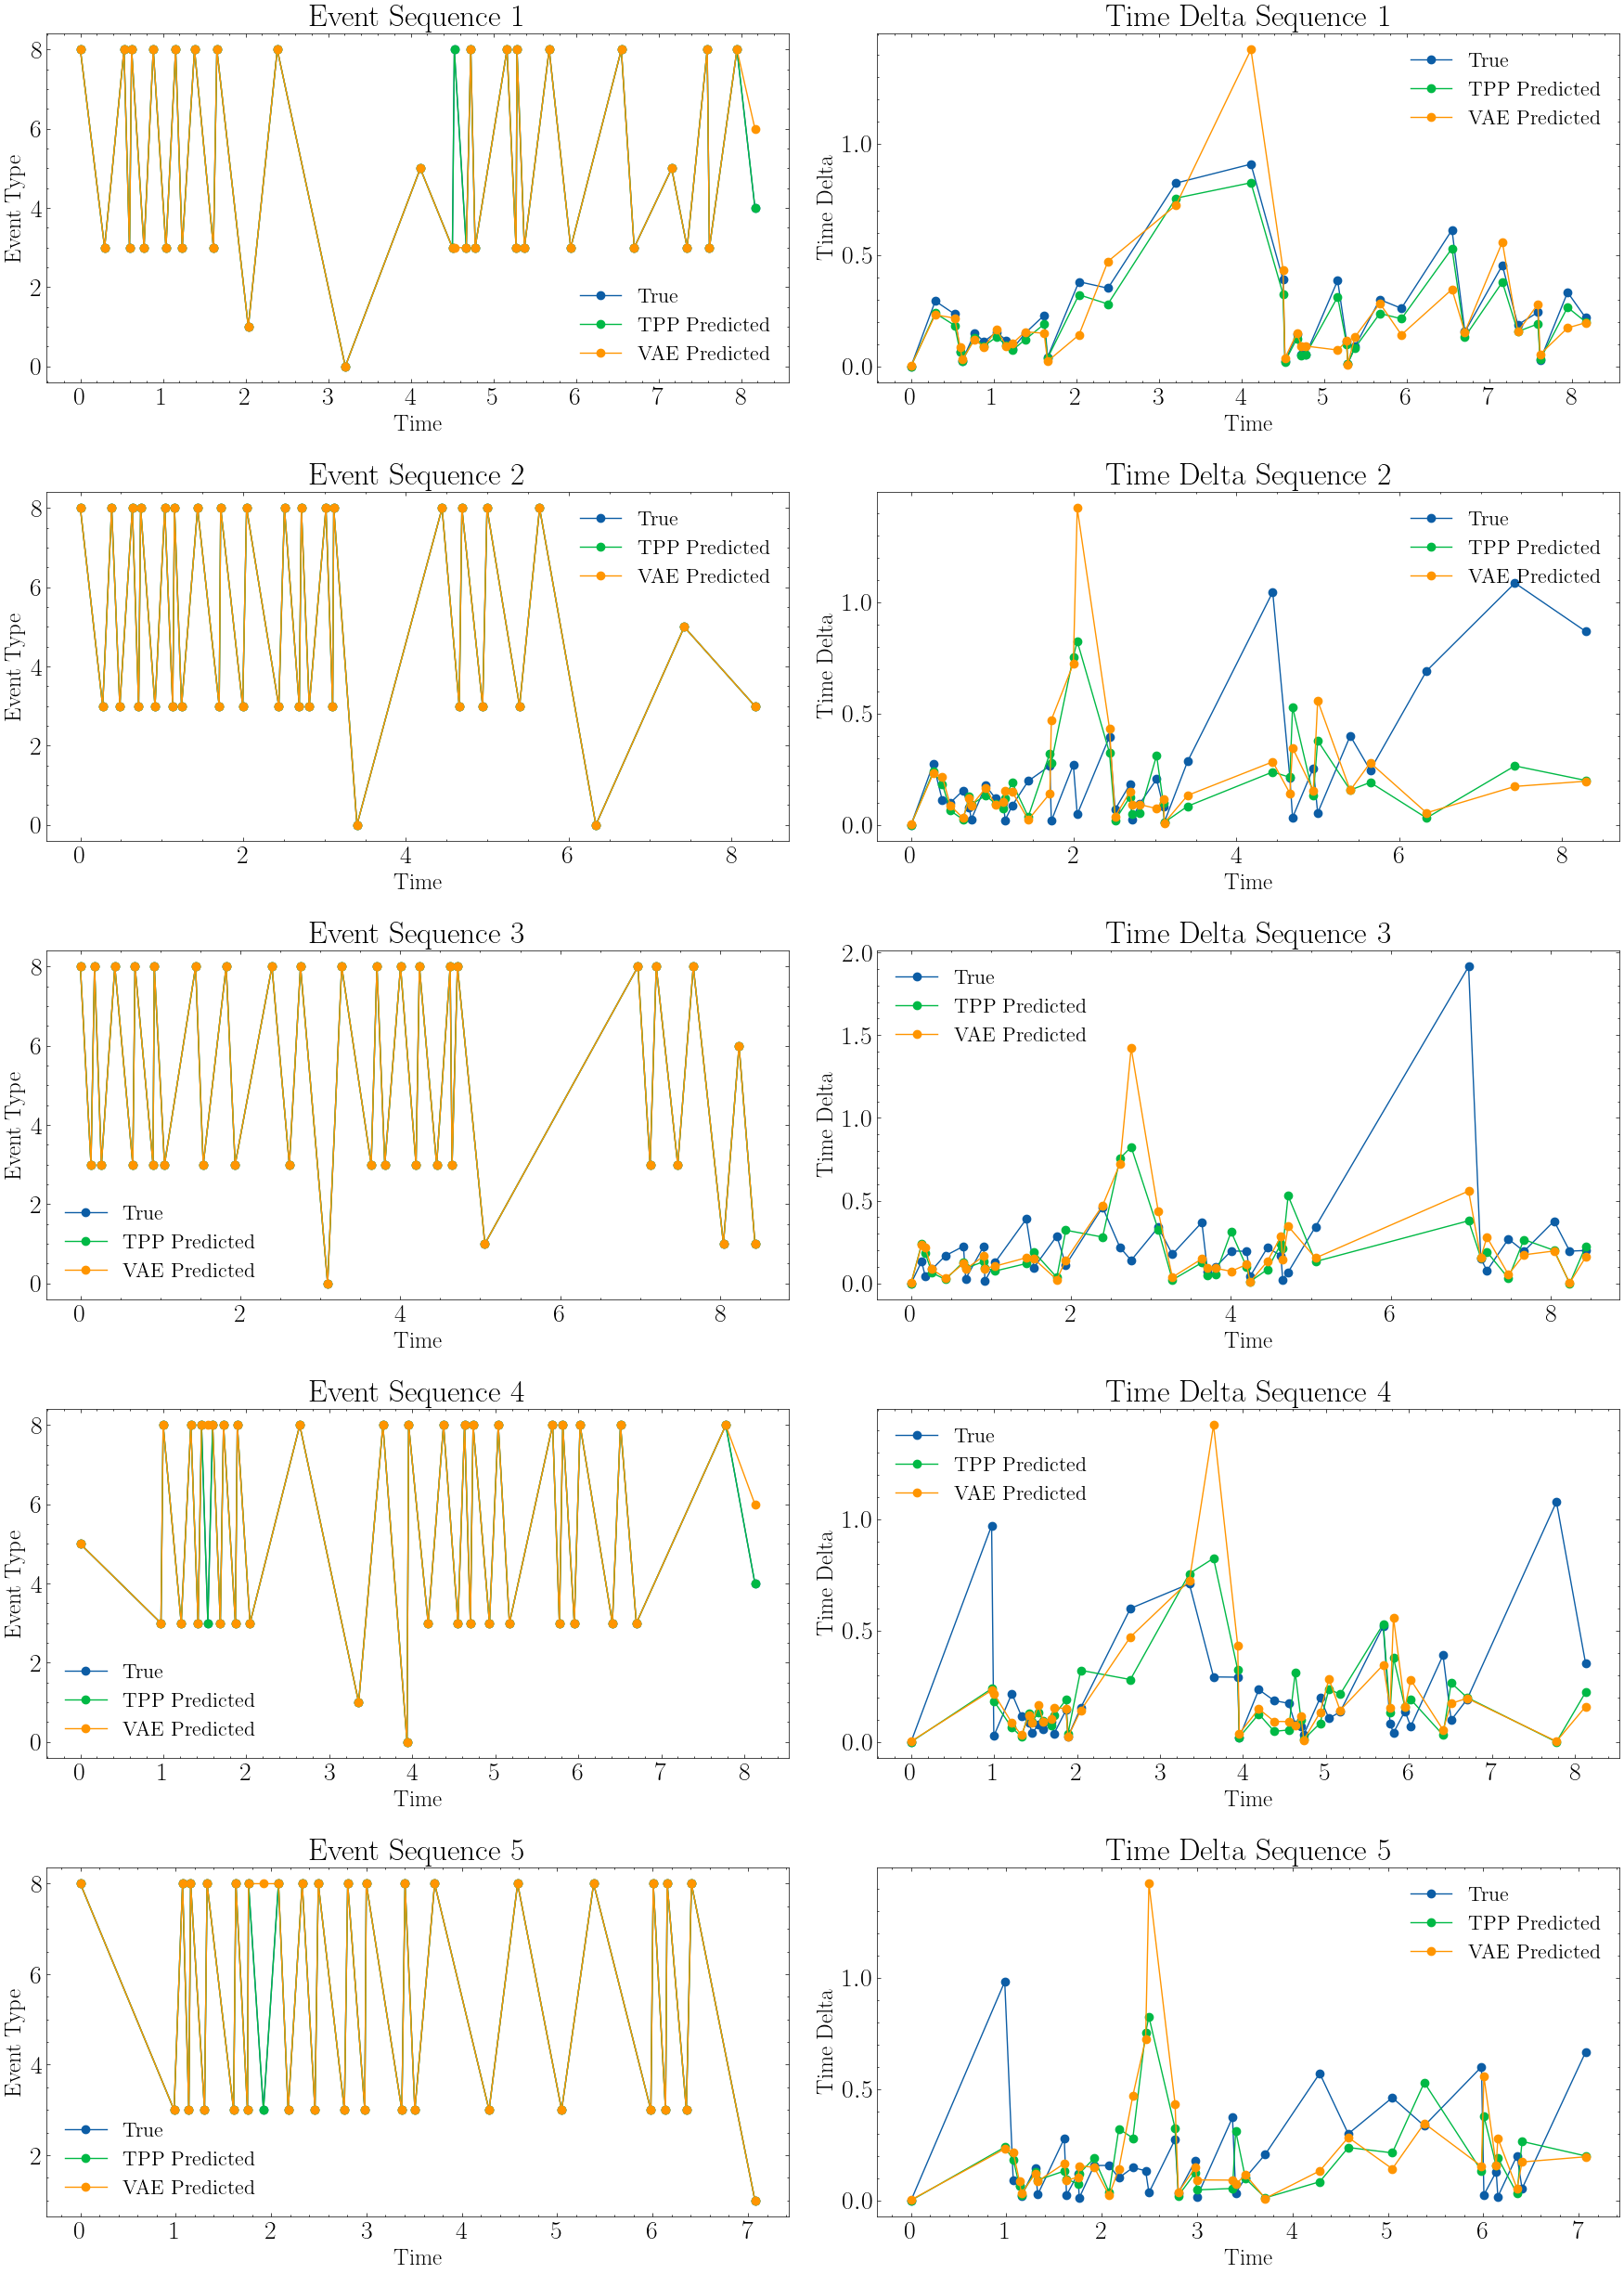

In [15]:
# Plotting both VAE and RMTPP event and time delta sequences
for batch in test_loader:
    batch = {k: v.to(device) for k, v in batch.items()}

    decoder_output_tpp = tpp_model(batch)
    decoder_output_vae = vae_model(batch)

    plot_seqs_both(
        batch["time_seqs"],
        batch["type_seqs"],
        batch["time_delta_seqs"],
        batch["sequence_length"],
        tpp_eval_metrics,
        vae_eval_metrics,
        decoder_output_tpp,
        decoder_output_vae,
        file_name="event_sequence_comparison.png",
    )
    break

In [16]:
# get and tabulate time mae, time rmse, mark accuracy in a table pandas
metric_keys = ['time_mae', 'time_rmse', 'event_accuracy']
tpp_df_metrics = {key: [tpp_eval_metrics[key]] for key in metric_keys}
tpp_df = pd.DataFrame.from_dict(tpp_df_metrics)

vae_df_metrics = {key: [vae_eval_metrics[key]] for key in metric_keys}
vae_df = pd.DataFrame.from_dict(vae_df_metrics)

df = pd.concat([tpp_df, vae_df], axis=0)
df.index = ['RMTPP', 'VAETPP']
# index column name
df.index.name = 'Architecture'
df.to_latex('metrics_table.tex', bold_rows=True)


### Visualizing Latent Spaces

Shape of mu: torch.Size([1216, 32])
Shape of mask: torch.Size([1216])
Shape of mu: torch.Size([1216, 32])
Shape of mask: torch.Size([1216])
Shape of mu: torch.Size([1216, 32])
Shape of mask: torch.Size([1216])
Shape of mu: torch.Size([1216, 32])
Shape of mask: torch.Size([1216])
Shape of mu: torch.Size([1216, 32])
Shape of mask: torch.Size([1216])
Shape of mu: torch.Size([1216, 32])
Shape of mask: torch.Size([1216])
Shape of mu: torch.Size([1216, 32])
Shape of mask: torch.Size([1216])
Shape of mu: torch.Size([1216, 32])
Shape of mask: torch.Size([1216])
Shape of mu: torch.Size([1216, 32])
Shape of mask: torch.Size([1216])
Shape of mu: torch.Size([1216, 32])
Shape of mask: torch.Size([1216])
Shape of mu: torch.Size([1216, 32])
Shape of mask: torch.Size([1216])
Shape of mu: torch.Size([1216, 32])
Shape of mask: torch.Size([1216])
Shape of mu: torch.Size([608, 32])
Shape of mask: torch.Size([608])
Shape before masking:
mus: (15200, 32)
event_types: (15200,)
masks: (15200,)

Shape after ma

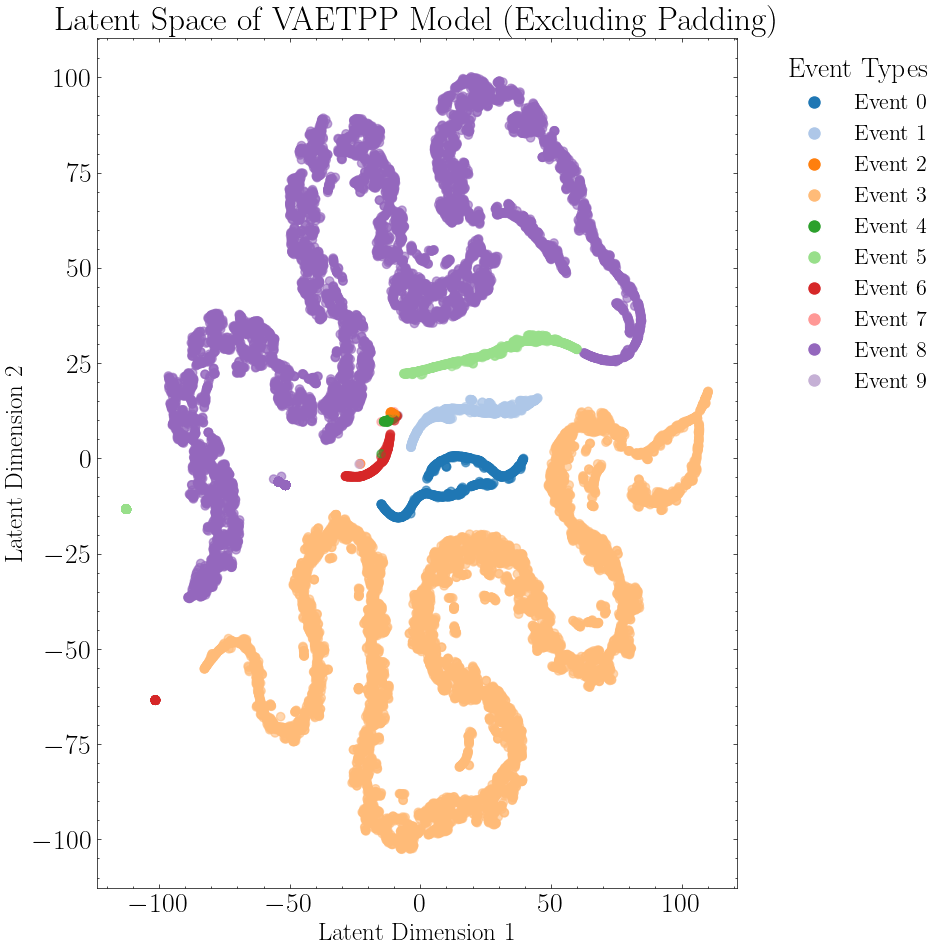

In [17]:
plot_latent_space_vae(vae_model, test_loader, device, file_name='vaetpp_latent_space.png')

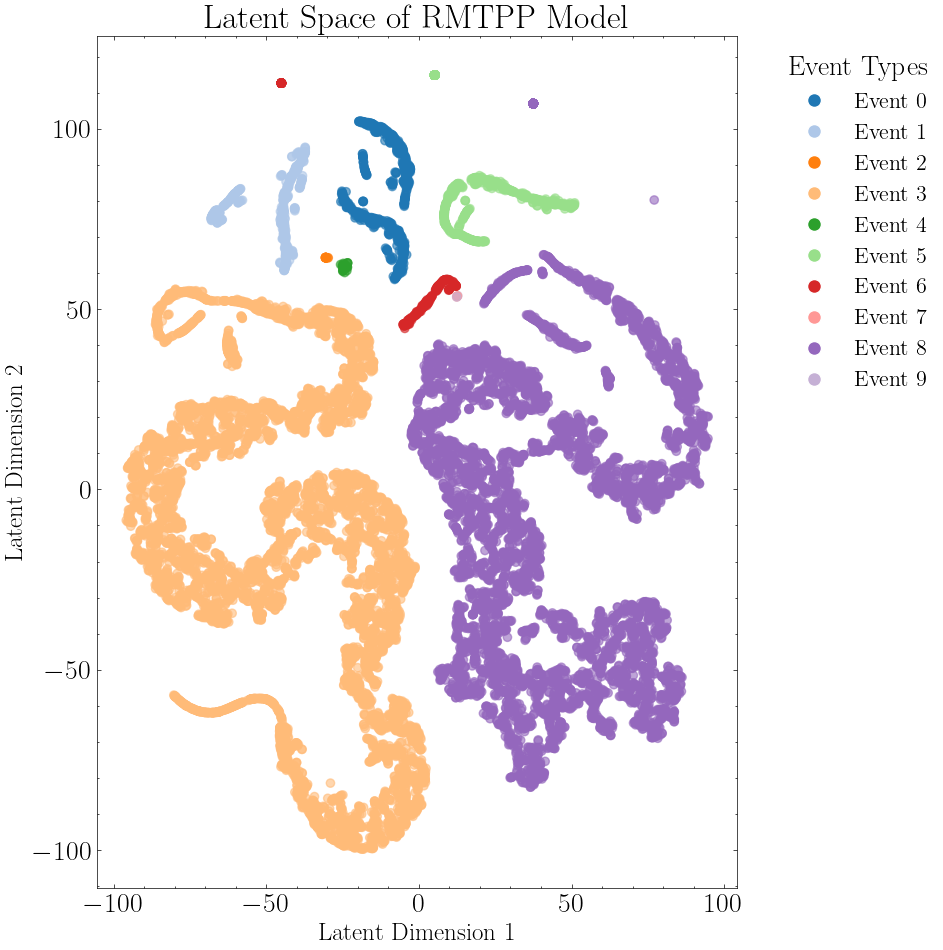

In [18]:
plot_latent_space_tpp(tpp_model, test_loader, device, file_name='latent_space_tpp.png')

NameError: name 'plt' is not defined

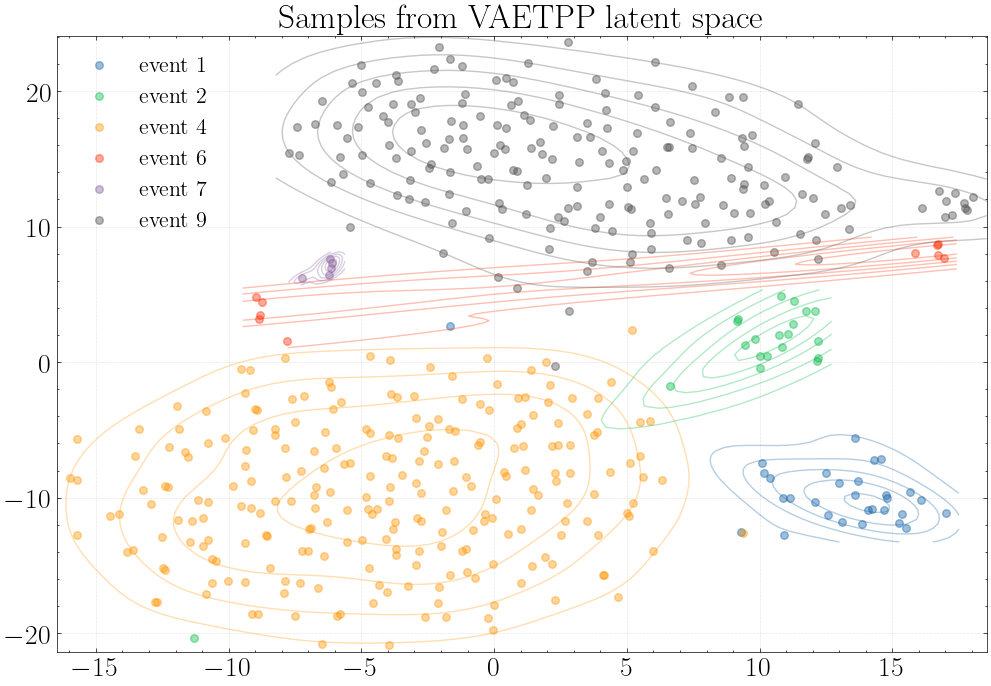

In [20]:
# Visualize samples from the VAE latent space
fig = plot_samples_vae(vae_model, test_loader, device, max_samples=100)